# Theory for $\delta T(x)$ accounting for changes in WTG and CE
This extends the $\delta h(x) = \delta \overline{h}$ theory for the tropics with an additional term accounting for the fact that the current climate differs from convective equilibrium (CE) and constant free troposphere temperature gradient (WTG). 

It also quantifies the effect of changes to these two terms with warming.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.stats import z_score_from_confidence_interval
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
from sklearn.linear_model import TheilSenRegressor
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-04-01 17:12:17,831 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 0.6
tau_lw_warm = 1
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Chose whether to only consider summer days or consider all days
season = 'all'
# season = 'summer'
# season = 'winter'
if season == 'summer':
    season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    season_months = {'nh': [12, 1, 2], 'sh': [6, 7, 8]}   # JJA for NH and DJF for SH

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:21<00:00, 10.83s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [5]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
z_mean = np.zeros((n_exp, n_pressure, n_lat))

# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting

with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.mean(dim='lon_time')
        mse = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], ds_all[i].height[ind_surf])
        mse_ft = moist_static_energy(ds_all[i].temp[ind_ft], sphum_sat(ds_all[i].temp[ind_ft], pressure_ft_actual), 
                                     ds_all[i].height[ind_ft])
        mse_mean[i, ind_surf] = mse.mean(dim='lon_time')
        mse_mean[i, ind_ft] = mse_ft.mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3[i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, :, k, j] = ds_all[i].height[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, ind_surf, k, j] = mse[k, use_ind].mean(dim='lon_time')
                mse_quant3[i, ind_ft, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

# Get kappa = z_ft / T_ft
kappa_quant3 = np.asarray([z_quant3[i, ind_ft] / temp_quant3[i, ind_ft] for i in range(n_exp)])
kappa_mean = np.asarray([np.expand_dims(z_mean[i, ind_ft]/temp_mean[i, ind_ft], axis=-1) for i in range(n_exp)])

100%|██████████| 2772/2772 [00:26<00:00, 103.86it/s]


## $\lambda_1$ Problem
Below, I show that $\lambda_1 = \delta h(x)/\delta h^*_{FT}(x)>1$ for all $x$ (blue line), and is larger for small $x$ when convection is not taking place. But the assumption of convective quasi-equilibrium expects $\lambda_1 \approx 1$.

I want to come up with a theory to explain why we don't see $\lambda_1 \approx 1$.

In [6]:
lambda_1 = (mse_quant3[1] - mse_quant3[0])[0] / (mse_quant3[1]-mse_quant3[0])[1]
lambda_2 = (mse_quant3[1]-mse_quant3[0])[1] / np.expand_dims(mse_mean[1]-mse_mean[0], axis=-1)[1]
lambda_3 = (mse_mean[1]-mse_mean[0])[0] / (mse_mean[1]-mse_mean[0])[1]
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']

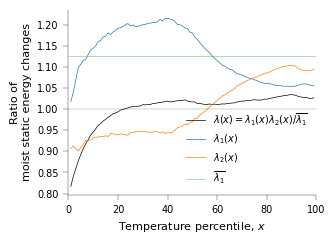

In [7]:
save_lambda_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i, var in enumerate([lambda_1*lambda_2/np.expand_dims(lambda_3, axis=-1), lambda_1, lambda_2]):
    use_color = 'k' if i == 0 else default_colors[i-1]
    ax.plot(quantiles_all, np.average(var, axis=0, weights=lat_weights),
            color=use_color, label=labels[i])
# ax.plot(quant_plot, np.average(lambda_1, axis=0, weights=lat_weights), color=default_colors[0], label=labels[1])
# ax.plot(quant_plot, np.average(lambda_2, axis=0, weights=lat_weights), color=default_colors[1])
ax.hlines(np.average(lambda_3, axis=0, weights=lat_weights), 0, 100, color=default_colors[2], alpha=0.5, label=labels[3])
ax.hlines(1, 0, 100, color='k', lw=ax_linewidth, alpha=0.5)
ax.legend()
ax.set_xlim(0, 100)
# ax.set_ylim(0.93, 1.27)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## MSE Perspective

In [9]:
def get_mse_ft_sat(temp_ft, kappa, pressure=pressure_ft_actual):
    """
    Function for computing saturated MSE from just free troposphere temperature.
    Args:
        temp_ft: [n_quant]
        kappa: [n_quant] or float
            Can either provide kappa (z/T ratio) for each quantile or just a single kappa value.
        pressure: float
            Free troposphere pressure in Pa.

    Returns:
        [n_quant]
            MSE in kJ/kg
    """
    return (c_p * temp_ft + L_v * sphum_sat(temp_ft, pressure) + g * kappa * temp_ft)/1000

def lambda_adiabat_fit_func(temp_ft, mse_surf, kappa):
    # Adiabatic FT temperature is such that surf MSE equals free trop MSE
    return get_mse_ft_sat(temp_ft, kappa) - mse_surf

In [10]:
# Repeat calculation of adiabatic free troposphere temperature, but this time let height vary with temperature
temp_adiabat_mean = np.zeros((n_exp, n_lat))
temp_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
for i in range(n_exp):
    for j in range(n_lat):
        temp_adiabat_mean[i, j] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, 
                                                                            args=(mse_mean[i, ind_surf, j], kappa_mean[i, j]))
        for k in range(n_quant_all):
            # MAYBE SHOULD COMPUTE THIS WITH kappa_quant. CHECK IF MAKES A DIFFERENCE!!
            temp_adiabat_quant3[i, j, k] = scipy.optimize.fsolve(lambda_adiabat_fit_func, 273, 
                                                                            args=(mse_quant3[i, ind_surf, j, k], kappa_mean[i, j]))

Text(0, 0.5, '$\\delta \\kappa$ [m/K]')

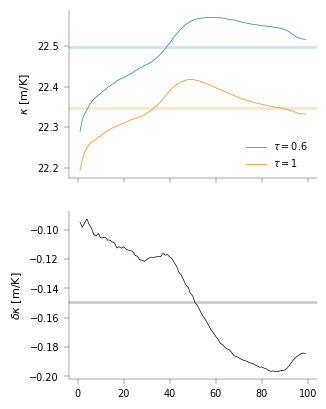

In [11]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(kappa_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].axhline(np.average(kappa_mean[i], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
ax[1].plot(quantiles_all, np.average(kappa_quant3[1] - kappa_quant3[0], axis=0, weights=lat_weights), color='k')
ax[1].axhline(np.average(kappa_mean[1] - kappa_mean[0], axis=0, weights=lat_weights), color='k', lw=2, alpha=0.2)
ax[0].legend()
ax[0].set_ylabel('$\kappa$ [m/K]')
ax[1].set_ylabel('$\delta \kappa$ [m/K]')

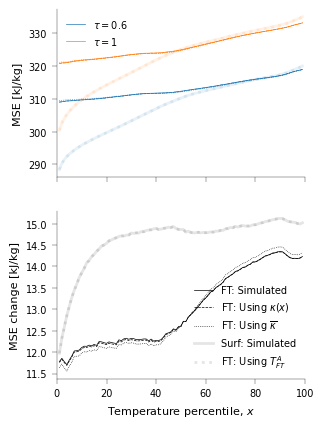

In [12]:
save_mse_ft_fig = False
mse_ft_sat_quant3 = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['kappa_x', 'kappa_mean', 'temp_adiabat']}
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    for j in range(n_lat):
        mse_ft_sat_quant3['kappa_x'][i, j] = get_mse_ft_sat(temp_quant3[i, ind_ft, j], kappa_quant3[i, j])
        mse_ft_sat_quant3['kappa_mean'][i, j] = get_mse_ft_sat(temp_quant3[i, ind_ft, j], kappa_mean[i, j])
        mse_ft_sat_quant3['temp_adiabat'][i, j] = get_mse_ft_sat(temp_adiabat_quant3[i, j], kappa_mean[i, j])
    ax[0].plot(quantiles_all, 
            np.average(mse_quant3[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_x'][i], axis=0, weights=lat_weights), 
               color=default_colors[i], linestyle='--')
    ax[0].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_mean'][i], axis=0, weights=lat_weights), 
               color=default_colors[i], linestyle=':')
    ax[0].plot(quantiles_all, np.average(mse_quant3[i, ind_surf], axis=0, weights=lat_weights), 
               color=default_colors[i], lw=2, alpha=0.1)
    ax[0].plot(quantiles_all, np.average(mse_ft_sat_quant3['temp_adiabat'][i], axis=0, weights=lat_weights), 
               color=default_colors[i], lw=2, alpha=0.1, linestyle=':')
ax[1].plot(quantiles_all, np.average(mse_quant3[1, ind_ft] - mse_quant3[0, ind_ft], axis=0, weights=lat_weights), color='k',
           label='FT: Simulated')
ax[1].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_x'][1] - mse_ft_sat_quant3['kappa_x'][0], axis=0, weights=lat_weights),
           color='k', linestyle='--', label='FT: Using $\kappa(x)$')
ax[1].plot(quantiles_all, np.average(mse_ft_sat_quant3['kappa_mean'][1] - mse_ft_sat_quant3['kappa_mean'][0], axis=0, weights=lat_weights),
           color='k', linestyle=':', label='FT: Using $\overline{\kappa}$')
ax[1].plot(quantiles_all, np.average(mse_quant3[1, ind_surf] - mse_quant3[0, ind_surf], axis=0, weights=lat_weights), color='k', 
           lw=2, alpha=0.1, label='Surf: Simulated')
ax[1].plot(quantiles_all, np.average(mse_ft_sat_quant3['temp_adiabat'][1] - mse_ft_sat_quant3['temp_adiabat'][0], axis=0,
                                     weights=lat_weights), color='k', lw=2, alpha=0.1, linestyle=':', label='FT: Using $T^A_{FT}$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('MSE [kJ/kg]')
ax[1].set_ylabel('MSE change [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_fig or save_mse_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_ft_sat_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [13]:
def get_h_anom_theory(temp_adiabat_mean, temp_adiabat_quant, kappa_mean, kappa_quant = None, p_ft = pressure_ft_actual,
                      include_squared_term=False):
    """
        Get h - h_mean theory using taylor expansion and free troposphere adiabatic temperatures.
    Args:
        temp_adiabat_mean: float
        temp_adiabat_quant: [n_quant]
        kappa_mean: float
        kappa_quant: [n_quant]
            If not given, assumes kappa_quant = kappa_mean i.e. no anomaly
        p_ft: float
        include_squared_term: bool

    Returns:
        [n_quant]
            MSE anomaly in kJ/kg
    """
    temp_adiabat_anom = temp_adiabat_quant - temp_adiabat_mean
    if kappa_quant is None:
        kappa_anom = 0
    else:
        kappa_anom = kappa_quant - kappa_mean
    alpha_mean = clausius_clapeyron_factor(temp_adiabat_mean, p_ft)
    q_sat_mean = sphum_sat(temp_adiabat_mean, p_ft)
    if include_squared_term:
        squared_term = 0.5 * L_v * alpha_mean * q_sat_mean / temp_adiabat_mean * (alpha_mean * temp_adiabat_mean - 2) * temp_adiabat_anom**2
    else:
        squared_term = 0
    return (c_p * temp_adiabat_anom + 
            L_v * q_sat_mean * alpha_mean * temp_adiabat_anom + 
            g * kappa_mean * temp_adiabat_anom + g * temp_adiabat_mean * kappa_anom + squared_term)/1000

def get_delta_temp_adiabat_mean_theory(temp_adiabat_mean, kappa_mean, mse_surf_mean, 
                                       temp_surf_mean = None, sphum_surf_mean = None, p_ft=pressure_ft_actual, p_surface=p_surface):
    """
    Assumes n_exp=2
    Args:
        temp_adiabat_mean: [n_exp]
        kappa_mean: [n_exp]
        mse_surf_mean: [n_exp]
            In units of kJ/kg
            If given, computes the exact difference in MSE surface. Otherwise, does linear expansion with temp_surf and sphum_surf.
        temp_surf_mean: [n_exp]
        sphum_surf_mean: [n_exp]
        p_ft: float (Pa)
        p_surface: float (Pa)

    Returns:
        float
    """
    if mse_surf_mean is not None:
        delta_mse = (mse_surf_mean[1] - mse_surf_mean[0]) * 1000        # convert into units of J/kg
    else:
        # Do linear taylor expansion to compute delta_mse if actual value not given
        delta_rh = float(np.diff(sphum_surf_mean / sphum_sat(temp_surf_mean, p_surface)))
        delta_temp_surf = temp_surf_mean[1] - temp_surf_mean[0]
        alpha_surf = clausius_clapeyron_factor(temp_surf_mean[0], p_surface)
        q_sat_surf = sphum_sat(temp_surf_mean[0], p_surface)
        delta_mse = (c_p + L_v * sphum_surf_mean[0] * alpha_surf) * delta_temp_surf + L_v * q_sat_surf * delta_rh
    delta_kappa = kappa_mean[1] - kappa_mean[0]
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    return (delta_mse - g * temp_adiabat_mean[0] * delta_kappa) / (c_p + L_v * alpha * q_sat + g * kappa_mean[0])

def get_delta_h_anom_theory(temp_adiabat_mean, temp_adiabat_quant, delta_temp_adiabat_mean, kappa_mean, kappa_quant = None,
                            include_squared_term=False, p_ft=pressure_ft_actual):
    """
    
    Args:
        temp_adiabat_mean: [n_exp]
        temp_adiabat_quant: [n_exp, n_quant]
        delta_temp_adiabat_mean: float
        kappa_mean: [n_exp]
        kappa_quant: [n_exp, n_quant]
            If not given, will set to same value as kappa_mean i.e. assume no variation in kappa with x.
        include_squared_term: bool
        p_ft: float

    Returns:
        [n_quant]
    """
    temp_anom = temp_adiabat_quant - temp_adiabat_mean[:, np.newaxis]
    delta_temp_anom = temp_anom[1] - temp_anom[0]
    if kappa_quant is None:
        kappa_anom = np.zeros_like(temp_anom)
    else:
        kappa_anom = kappa_quant - kappa_mean[:, np.newaxis]
    delta_kappa_mean = kappa_mean[1] - kappa_mean[0]
    delta_kappa_anom = kappa_anom[1] - kappa_anom[0]
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    
    temp_anom_prefactor = c_p + g * kappa_mean[0] + L_v * q_sat * alpha
    temp_mean_prefactor = g * kappa_anom[0] + L_v * q_sat * alpha / temp_adiabat_mean[0] * (temp_adiabat_mean[0] * alpha - 2) * temp_anom[0]
    kappa_anom_prefactor = g * temp_adiabat_mean[0]
    kappa_mean_prefactor = g * temp_anom[0]
    if include_squared_term:
        temp_anom_squared_prefactor = 0.5 * L_v * q_sat * alpha / temp_adiabat_mean[0] * (temp_adiabat_mean[0] * alpha - 2)
        temp_anom_prefactor = temp_anom_prefactor + 2 * temp_anom_squared_prefactor * temp_anom[0]
        temp_mean_squared_prefactor = 0.5 * L_v * q_sat * alpha / temp_adiabat_mean[0]**2 * (
                alpha**2 * temp_adiabat_mean[0]**2 - 6 * alpha * temp_adiabat_mean[0] + 6) * temp_anom[0]  # only include one term
        temp_mean_prefactor = temp_mean_prefactor + temp_mean_squared_prefactor * temp_anom[0]
    else:
        temp_anom_squared_prefactor = 0
        temp_mean_squared_prefactor = 0
        
    # Convert into units of kJ/kg
    temp_anom_prefactor = temp_anom_prefactor/1000
    temp_anom_squared_prefactor = temp_anom_squared_prefactor/1000
    kappa_anom_prefactor = kappa_anom_prefactor/1000
    kappa_mean_prefactor = kappa_mean_prefactor/1000
    temp_mean_prefactor = temp_mean_prefactor/1000
    temp_mean_squared_prefactor = temp_mean_squared_prefactor/1000
    full_answer = temp_anom_prefactor * delta_temp_anom + temp_anom_squared_prefactor * delta_temp_anom**2 + \
                  kappa_anom_prefactor * delta_kappa_anom + kappa_mean_prefactor * delta_kappa_mean + \
                  temp_mean_prefactor * delta_temp_adiabat_mean + temp_mean_squared_prefactor * delta_temp_adiabat_mean**2
    info_dict = {'temp_anom': [temp_anom_prefactor, delta_temp_anom], 
                 'temp_anom_squared': [temp_anom_squared_prefactor, delta_temp_anom**2],
                 'temp_mean': [temp_mean_prefactor, delta_temp_adiabat_mean],
                 'temp_mean_squared': [temp_mean_squared_prefactor, delta_temp_adiabat_mean**2],
                 'kappa_anom': [kappa_anom_prefactor, delta_kappa_anom], 
                 'kappa_mean': [kappa_mean_prefactor, delta_kappa_mean]}
    return full_answer, info_dict

def get_delta_h_anom_theory_simple(temp_adiabat_mean, temp_adiabat_quant, delta_mse_mean, kappa_mean, kappa_quant = None, 
                                   p_ft=pressure_ft_actual):
    """
    
    Args:
        temp_adiabat_mean: [n_exp]
        temp_adiabat_quant: [n_exp, n_quant]
        delta_mse_mean: float
            Needs to be in units of J/kg
        kappa_mean: [n_exp]
        kappa_quant: [n_exp, n_quant]
            If not given, will set to same value as kappa_mean i.e. assume no variation in kappa with x.
        p_ft: float
            In units of Pa

    Returns:
        [n_quant]
    """
    temp_anom = temp_adiabat_quant - temp_adiabat_mean[:, np.newaxis]
    delta_temp_anom = temp_anom[1] - temp_anom[0]
    if kappa_quant is None:
        kappa_anom = np.zeros_like(temp_anom)
    else:
        kappa_anom = kappa_quant - kappa_mean[:, np.newaxis]
    delta_kappa_mean = kappa_mean[1] - kappa_mean[0]
    delta_kappa_anom = kappa_anom[1] - kappa_anom[0]
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    
    beta = c_p + L_v * alpha * q_sat + g * kappa_mean[0]                # this is a float
    beta_2 = L_v * alpha * q_sat * (alpha * temp_adiabat_mean[0] - 2)   # this is a float, same units as beta
    temp_anom_prefactor = beta
    mse_prefactor = beta_2 * temp_anom[0] / (beta * temp_adiabat_mean[0]) + g * kappa_anom[0] / beta
    kappa_mean_prefactor = g * temp_anom[0] * (1 - beta_2/beta) - g**2 * temp_adiabat_mean[0] * kappa_anom[0]/beta
    kappa_anom_prefactor = g * temp_adiabat_mean[0]
    
    # Convert into units of kJ/kg
    temp_anom_prefactor = temp_anom_prefactor/1000
    mse_prefactor = mse_prefactor/1000
    kappa_anom_prefactor = kappa_anom_prefactor/1000
    kappa_mean_prefactor = kappa_mean_prefactor/1000
    
    full_answer = temp_anom_prefactor * delta_temp_anom + mse_prefactor * delta_mse_mean + kappa_mean_prefactor * delta_kappa_mean + kappa_anom_prefactor * delta_kappa_anom
    
    info_dict = {'temp_anom': [temp_anom_prefactor, delta_temp_anom], 
             'mse_mean': [mse_prefactor, delta_mse_mean],
             'kappa_anom': [kappa_anom_prefactor, delta_kappa_anom], 
             'kappa_mean': [kappa_mean_prefactor, delta_kappa_mean]}
    
    return full_answer, info_dict

In [14]:
delta_temp_adiabat_mean = {'simulated': temp_adiabat_mean[1]-temp_adiabat_mean[0], 
                           'full_delta_mse': np.zeros(n_lat), 'linear_delta_mse': np.zeros(n_lat)}
h_anom_theory = {'linear': np.zeros((n_exp, n_lat, n_quant_all)), 'squared': np.zeros((n_exp, n_lat, n_quant_all))}
delta_h_anom = {'simulated': np.diff(mse_quant3[:, ind_surf] - mse_mean[:, ind_surf][:, :, np.newaxis], axis=0)[0], 
                'linear': np.zeros((n_lat, n_quant_all)), 'squared': np.zeros((n_lat, n_quant_all)), 
                'simple': np.zeros((n_lat, n_quant_all))}
delta_h_anom_theory_prefactors = {key: np.zeros((n_lat, n_quant_all)) for key in 
                           ['temp_anom', 'temp_anom_squared', 'temp_mean', 'temp_mean_squared', 'kappa_anom', 'kappa_mean']}
delta_h_anom_theory_diff = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_prefactors}
delta_h_anom_theory_cont = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_prefactors}

delta_h_anom_theory_simple_prefactors = {key: np.zeros((n_lat, n_quant_all)) for key in 
                                         ['temp_anom', 'mse_mean', 'kappa_anom', 'kappa_mean']}
delta_h_anom_theory_simple_diff = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_simple_prefactors}
delta_h_anom_theory_simple_cont = {key: np.zeros((n_lat, n_quant_all)) for key in delta_h_anom_theory_simple_prefactors}
for j in range(n_lat):
    for key in ['full_delta_mse', 'linear_delta_mse']:
        delta_temp_adiabat_mean[key][j] = \
            get_delta_temp_adiabat_mean_theory(temp_adiabat_mean[:, j], 
                                               kappa_mean[:, j], None if 'linear' in key else mse_mean[:, ind_surf, j], 
                                               temp_mean[:, ind_surf, j], sphum_mean[:, j])[0]
    for key in ['linear', 'squared']:
        # I use full_delta_mse here for delta_temp_adiabat_mean term, but doesn't make too much difference.
        delta_h_anom[key][j], info = get_delta_h_anom_theory(temp_adiabat_mean[:, j], temp_adiabat_quant3[:, j],
                                                          delta_temp_adiabat_mean['full_delta_mse'][j], kappa_mean[:, j],
                                                          include_squared_term=True if key=='squared' else False)
        if key == 'linear':
            # Only get individual contributions from linear theory
            for key in info:
                delta_h_anom_theory_prefactors[key][j] = info[key][0]
                delta_h_anom_theory_diff[key][j] = info[key][1]
                delta_h_anom_theory_cont[key][j] = delta_h_anom_theory_prefactors[key][j] * delta_h_anom_theory_diff[key][j]
    delta_h_anom['simple'][j], info = \
        get_delta_h_anom_theory_simple(temp_adiabat_mean[:, j], temp_adiabat_quant3[:, j],
                                       (mse_mean[1, ind_surf, j] - mse_mean[0, ind_surf, j])*1000, kappa_mean[:, j])
    for key in info:
        delta_h_anom_theory_simple_prefactors[key][j] = info[key][0]
        delta_h_anom_theory_simple_diff[key][j] = info[key][1]
        delta_h_anom_theory_simple_cont[key][j] = delta_h_anom_theory_simple_prefactors[key][j] * delta_h_anom_theory_simple_diff[key][j]
    for i in range(n_exp):
        for key in h_anom_theory:
            h_anom_theory[key][i, j] = get_h_anom_theory(temp_adiabat_mean[i, j], temp_adiabat_quant3[i, j], 
                                                         kappa_mean[i, j], include_squared_term=True if key=='squared' else False)

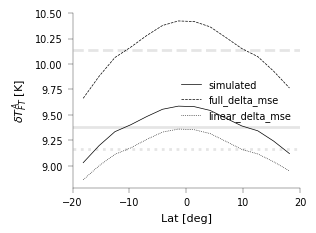

In [15]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
linestyles_use = ['-', '--', ':']
for i, key in enumerate(delta_temp_adiabat_mean):
    ax.plot(ds_all[0].lat, delta_temp_adiabat_mean[key], color='k', label=key, linestyle=linestyles_use[i])
    ax.axhline(np.average(delta_temp_adiabat_mean[key], weights=lat_weights, axis=0), color='k', 
               linestyle=linestyles_use[i], lw=2, alpha=0.1)
ax.set_xlim(-lat_max, lat_max)
ax.set_ylabel('$\delta T_{FT}^A$ [K]')
ax.set_xlabel('Lat [deg]')
ax.legend()
plt.tight_layout()

Below, the linear red line captures the broad trend we are after.

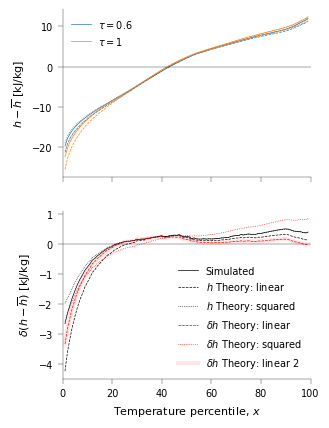

In [16]:
save_mse_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(mse_quant3[i, ind_surf] - mse_mean[i, ind_surf][:, np.newaxis], axis=0, weights=lat_weights),
               color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['linear'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle='--')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['squared'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle=':')
ax[1].plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k', label='Simulated')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['linear'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle='--', label='$h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['squared'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle=':', label='$h$ Theory: squared')
ax[1].plot(quantiles_all, np.average(delta_h_anom['linear'], axis=0, weights=lat_weights), 
           color='r', linestyle='--', label='$\delta h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(delta_h_anom['squared'], axis=0, weights=lat_weights), 
           color='r', linestyle=':', label='$\delta h$ Theory: squared')
ax[1].plot(quantiles_all, np.average(delta_h_anom['simple'], axis=0, weights=lat_weights), 
           color='r', label='$\delta h$ Theory: linear 2', lw=3, alpha=0.1)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$h-\overline{h}$ [kJ/kg]')
ax[1].set_ylabel('$\delta (h-\overline{h})$ [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_mse_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

(0.0, 100.0)

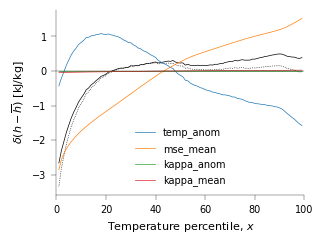

In [17]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k')
ax.plot(quantiles_all, np.average(delta_h_anom['simple'], axis=0, weights=lat_weights), 
           color='k', linestyle=':')
for i, key in enumerate(delta_h_anom_theory_simple_cont):
    # if ('squared' in key) or (key == 'kappa_anom'):
    #     continue
    ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont[key], axis=0, weights=lat_weights), 
           color=default_colors[i], label=key)
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\delta (h-\overline{h})$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

## Climatological $\Delta T_A$ Breakdown
The variation in the $\delta \overline{h}$ contribution is caused by the variation of $\Delta T^A(x)$ with $x$ in the current climate.
We can decompose this into a WTG and two Convective Equilibrium (CE) terms:
$\Delta T^A_{WTG}(x) = T_{FT}(x) - \overline{T_{FT}}$
$\Delta T^A_{CE}(x) = T_{FT}(x) - T^A_{FT}(x)$
$\Delta \overline{T^A_{CE}} = \overline{T_{FT}} - \overline{T^A_{FT}}$

Putting everything together, we have:
$\Delta T^A(x) = T^A_{FT}(x) - \overline{T^A_{FT}} = \Delta T^A_{WTG}(x) - \Delta T^A_{CE}(x) + \Delta \overline{T^A_{CE}}$

If WTG and CE were both valid in the current climate, then clearly $\Delta T^A(x) = 0$ and the `mse_mean` term in the above plot would be 0.

Equally, we can decompose the change in the anomaly with warming, $\delta \Delta T^A(x)$:
$\delta (\Delta T^A(x)) = \delta (T^A_{FT}(x) - \overline{T^A_{FT}}) = \delta (\Delta T^A_{WTG}(x)) - \delta(\Delta T^A_{CE}(x)) + \delta(\Delta \overline{T^A_{CE}})$

In convective-quasi equilibrium, we would expect $\delta(\Delta T^A_{CE}(x)) \approx \delta(\Delta \overline{T^A_{CE}}) \approx 0$. If WTG remained valid, we would expect $\delta (\Delta T^A_{WTG}(x)) \approx 0$. Together, they would give $\delta (\Delta T^A(x)) \approx 0$.

It seems that WTG is pretty well satisfied, and the main trend comes from the convection part.
If convection becomes more prevalent on all days that are not yet convecting, the climatological $\Delta T^A_{CE}$ and the change $\delta \Delta T^A_{CE}$ oppose each other. This happens for small $x$.

If a climate is convecting i.e. $\Delta T^A_{CE} < 0$ and CAPE increases with warming i.e. $\delta \Delta T^A_{CE} < 0$ then they reinforce each other. This happens at large $x$.

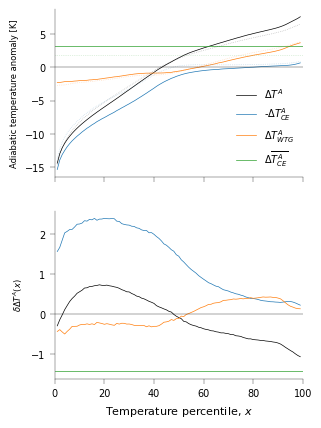

In [18]:
temp_adiabat_anom = temp_adiabat_quant3 - temp_adiabat_mean[:, :, np.newaxis]
temp_wtg_anom = temp_quant3[:, ind_ft] - temp_mean[:, ind_ft][:, :, np.newaxis]
temp_ce_quant_anom = temp_quant3[:, ind_ft] - temp_adiabat_quant3
temp_ce_mean_anom = temp_mean[:, ind_ft] - temp_adiabat_mean

save_temp_adiabat_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = ['-', ':']
alpha_use = [1, 0.3]
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(temp_adiabat_anom[i], weights=lat_weights, axis=0), color='k', 
               label='$\Delta T^A$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].plot(quantiles_all, -np.average(temp_ce_quant_anom[i], weights=lat_weights, axis=0), color=default_colors[0], 
               label='-$\Delta T^A_{CE}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom[i], weights=lat_weights, axis=0), color=default_colors[1], 
               label='$\Delta T^A_{WTG}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].axhline(np.average(temp_ce_mean_anom[i], weights=lat_weights, axis=0), color=default_colors[2], 
                  label='$\Delta \overline{T^A_{CE}}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
ax[1].plot(quantiles_all, np.average(temp_adiabat_anom[1]-temp_adiabat_anom[0], weights=lat_weights, axis=0), color='k')
ax[1].plot(quantiles_all, -np.average(temp_ce_quant_anom[1]-temp_ce_quant_anom[0], weights=lat_weights, axis=0), color=default_colors[0])
ax[1].plot(quantiles_all, np.average(temp_wtg_anom[1] - temp_wtg_anom[0], weights=lat_weights, axis=0), color=default_colors[1])
ax[1].axhline(np.average(temp_ce_mean_anom[1]-temp_ce_mean_anom[0], weights=lat_weights, axis=0), color=default_colors[2])
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Adiabatic temperature anomaly [K]', fontsize=6)
ax[1].set_ylabel('$\delta \Delta T^A(x)$', fontsize=6)

if save_fig or save_temp_adiabat_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_adiabat_anom_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

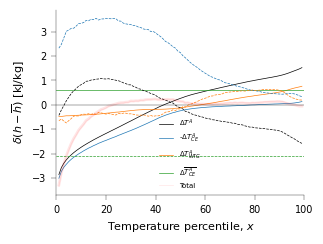

In [19]:
save_mse_anom_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont['mse_mean'], weights=lat_weights, axis=0), 
        color='k', label='$\Delta T^A$')
prefactor_use = delta_h_anom_theory_simple_cont['mse_mean'] / temp_adiabat_anom[0]      # [n_lat, n_quant] but same for each quant
ax.plot(quantiles_all, -np.average(prefactor_use * temp_ce_quant_anom[0], weights=lat_weights, axis=0), 
        color=default_colors[0], label='-$\Delta T^A_{CE}$')
ax.plot(quantiles_all, np.average(prefactor_use * temp_wtg_anom[0], weights=lat_weights, axis=0), 
        color=default_colors[1], label='$\Delta T^A_{WTG}$')
ax.axhline(np.average(prefactor_use[:, 0] * temp_ce_mean_anom[0], weights=lat_weights, axis=0), color=default_colors[2], 
           label='$\Delta \overline{T^A_{CE}}$')
prefactor_use = delta_h_anom_theory_simple_prefactors['temp_anom']
ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont['temp_anom'], weights=lat_weights, axis=0), 
        color='k', linestyle='--')
ax.plot(quantiles_all, -np.average(prefactor_use * (temp_ce_quant_anom[1]-temp_ce_quant_anom[0]), weights=lat_weights, axis=0), 
        color=default_colors[0], linestyle='--')
ax.plot(quantiles_all, np.average(prefactor_use * (temp_wtg_anom[1]-temp_wtg_anom[0]), weights=lat_weights, axis=0), 
        color=default_colors[1], linestyle='--')
ax.axhline(np.average(prefactor_use[:, 0] * (temp_ce_mean_anom[1]-temp_ce_mean_anom[0]), weights=lat_weights, axis=0), 
           color=default_colors[2], linestyle='--')
ax.plot(quantiles_all, np.average(delta_h_anom_theory_simple_cont['mse_mean'] + delta_h_anom_theory_simple_cont['temp_anom'],
                                  weights=lat_weights, axis=0), color='r', lw=2, alpha=0.1)
ax.plot(quantiles_all, np.average(delta_h_anom['simple'], weights=lat_weights, axis=0), color='r', alpha=0.1, label='Total')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend(fontsize=5)
ax.set_ylabel('$\delta (h-\overline{h})$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

if save_fig or save_mse_anom_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_decomp_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)